In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import shapiro
import statsmodels.api as sm
import numpy as np
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit


In [129]:
# Wczytaj dane z pliku CSV
data = pd.read_csv('Prognoza_transformed.csv', sep=',' ,parse_dates=['date'])

data.head(5)


,date,ilosc,articles,customers,year,month,day,day_of_year,week_of_year,quarter,...,is_last_days,is_weak_month,is_saturday,is_first_days,ilosc_log,ilosc_log_std,customers_log,customers_log_std,articles_log,articles_log_std
0,2022-01-03,7.072,7,3,2022,1,3,3,1,1,...,0,0,0,1,2.088401,-3.619092,1.386294,-6.906660,2.079442,-6.062106
1,2022-01-04,230.061,415,35,2022,1,4,4,1,1,...,0,0,0,1,5.442682,-0.377503,3.583519,-1.220855,6.030685,-0.641179
2,2022-01-05,115.141,411,37,2022,1,5,5,1,1,...,0,0,0,1,4.754805,-1.042270,3.637586,-1.080944,6.021023,-0.654435
3,2022-01-10,148.733,434,47,2022,1,10,10,2,1,...,0,0,0,0,5.008854,-0.796756,3.871201,-0.476414,6.075346,-0.579906
4,2022-01-11,505.648,896,53,2022,1,11,11,2,1,...,0,0,0,0,6.227816,0.381254,3.988984,-0.171624,6.799056,0.412991


In [3]:
data.describe()

,date,ilosc,articles,customers,year,month,day,day_of_year,week_of_year,quarter,...,is_last_days,is_weak_month,is_saturday,is_first_days,ilosc_log,ilosc_log_std,customers_log,customers_log_std,articles_log,articles_log_std
count,614,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,6.140000e+02,614.000000,6.140000e+02
mean,2023-03-24 21:36:56.286644992,639.469485,823.167752,59.705212,2022.780130,5.894137,15.983713,164.153094,23.843648,2.301303,...,0.097720,0.275244,0.003257,0.148208,5.833309,0.000000,4.055307,1.643275e-15,6.498032,-2.430195e-16
min,2022-01-03 00:00:00,0.221000,1.000000,1.000000,2022.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.199670,-5.444369,0.693147,-8.700332e+00,0.693147,-7.964039e+00
25%,2022-08-13 00:00:00,182.104000,488.500000,52.000000,2022.000000,3.000000,8.250000,74.000000,11.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,5.210054,-0.602315,3.970292,-2.199942e-01,6.193383,-4.179651e-01
50%,2023-03-22 12:00:00,260.117000,636.500000,59.000000,2023.000000,5.000000,16.000000,150.500000,22.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,5.564965,-0.259328,4.094345,1.010196e-01,6.457554,-5.553441e-02
75%,2023-11-01 12:00:00,556.920000,862.750000,67.000000,2023.000000,9.000000,23.000000,251.750000,36.000000,3.000000,...,0.000000,1.000000,0.000000,0.000000,6.324216,0.474414,4.219508,4.249069e-01,6.761283,3.611684e-01
max,2024-06-18 00:00:00,7589.803000,4577.000000,124.000000,2024.000000,12.000000,31.000000,364.000000,52.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,8.934693,2.997189,4.828314,2.000327e+00,8.429018,2.649224e+00
std,NaN,1023.360409,634.598299,16.194356,0.739602,3.415758,8.684035,104.116602,14.839379,1.109987,...,0.297178,0.447001,0.057026,0.355596,1.035608,1.000815,0.386755,1.000815e+00,0.729481,1.000815e+00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               614 non-null    datetime64[ns]
 1   ilosc              614 non-null    float64       
 2   articles           614 non-null    int64         
 3   customers          614 non-null    int64         
 4   year               614 non-null    int64         
 5   month              614 non-null    int64         
 6   day                614 non-null    int64         
 7   day_of_year        614 non-null    int64         
 8   week_of_year       614 non-null    int64         
 9   quarter            614 non-null    int64         
 10  season             614 non-null    int64         
 11  month_sin          614 non-null    float64       
 12  month_cos          614 non-null    float64       
 13  day_sin            614 non-null    float64       
 14  day_cos   

## Podział danych

In [5]:
data['date'] = pd.to_datetime(data['date'])

In [6]:
train_start_date = '2022-01-02'
train_end_date = '2023-12-31'
test_start_date = '2024-01-01'
test_end_date = '2024-06-18'

In [7]:
train_data = data[(data['date'] >= train_start_date) & (data['date'] <= train_end_date)]
test_data = data[(data['date'] >= test_start_date) & (data['date'] <= test_end_date)]

In [8]:
dependent_variable = 'ilosc'
X_train = train_data.drop(columns=['ilosc', 'ilosc_log', 'ilosc_log_std'])
y_train = train_data[dependent_variable]
X_test = test_data.drop(columns=['ilosc', 'ilosc_log', 'ilosc_log_std'])
y_test = test_data[dependent_variable]

In [9]:
dependent_variable = 'ilosc_log_std'
X_train_log = train_data.drop(columns=['ilosc', 'ilosc_log', 'ilosc_log_std'])
y_train_log = train_data[dependent_variable]
X_test_log = test_data.drop(columns=['ilosc', 'ilosc_log', 'ilosc_log_std'])
y_test_log = test_data[dependent_variable]

## Model dla artykułów

In [ ]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Wczytaj dane z pliku CSV
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje
data = data.groupby(['DATA_W', 'ArticleID']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Wyświetl pierwsze kilka wierszy przetworzonych danych
print(data.head())

# Wybierz 5 artykułów z najwyższą liczbą obserwacji
top_articles = data['articleid'].value_counts().nlargest(5).index

# Agregacja danych dziennych dla wybranych artykułów
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
aggregated_data = data[data['articleid'].isin(top_articles)].groupby(['articleid', pd.Grouper(freq='D')]).sum().reset_index()

# Logarytmizacja i standaryzacja zmiennej 'ilosc' dla każdego artykułu
article_models = {}
for article_id in aggregated_data['articleid'].unique():
    article_data = aggregated_data[aggregated_data['articleid'] == article_id].copy()
    
    # Sprawdzenie liczby obserwacji
    if len(article_data) < 8:  # Sprawdzenie, czy mamy wystarczająco dużo danych (8 tygodni)
        print(f'Article ID: {article_id} ma za mało danych do trenowania modelu.')
        continue

    # Sprawdzenie stacjonarności danych
    result = adfuller(article_data['ilosc'])
    if result[1] > 0.05:
        print(f'Article ID: {article_id} dane nie są stacjonarne, pomijamy.')
        continue
    
    # Logarytmizacja zmiennej 'ilosc'
    article_data['ilosc_log'] = np.log(article_data['ilosc'] + 1)

    # Standaryzacja zmiennej 'ilosc_log'
    scaler = StandardScaler()
    article_data['ilosc_log_std'] = scaler.fit_transform(article_data[['ilosc_log']])

    # Podział danych na zestaw treningowy i testowy
    train_size = int(len(article_data) * 0.8)
    train, test = article_data.iloc[:train_size], article_data.iloc[train_size:]

    # Dane zależne i zmienne egzogeniczne (jeśli istnieją)
    y_train = train['ilosc_log_std']
    y_test = test['ilosc_log_std']
    X_train = train[['articles']] if 'articles' in train.columns else None
    X_test = test[['articles']] if 'articles' in test.columns else None

    # Model ARIMA
    model = pm.ARIMA(
        order=(1, 0, 0),
        seasonal_order=(3, 0, 0, 365)  # Uproszczony model z sezonowością roczną
    )

    # Trenowanie modelu
    try:
        if X_train is not None:
            model.fit(y_train, exogenous=X_train)
        else:
            model.fit(y_train)
    except Exception as e:
        print(f'Nie udało się dopasować modelu dla Article ID: {article_id}. Błąd: {e}')
        continue

    # Prognozowanie na zestawie testowym
    if X_test is not None:
        forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
    else:
        forecast = model.predict(n_periods=len(y_test))

    # Odwrócenie standaryzacji i logarytmizacji prognoz
    forecast_original_scale = np.exp(scaler.inverse_transform(forecast.values.reshape(-1, 1))) - 1
    y_test_original_scale = np.exp(scaler.inverse_transform(y_test.values.reshape(-1, 1))) - 1

    # Obliczenie metryk na oryginalnej skali
    mse = mean_squared_error(y_test_original_scale, forecast_original_scale)
    mae = mean_absolute_error(y_test_original_scale, forecast_original_scale)

    # Obliczenie procentowej różnicy
    mean_sales = np.mean(article_data['ilosc'])
    normalized_mse = mse / mean_sales**2
    mae_percentage = (mae / mean_sales) * 100

    # Wyświetlenie wyników
    print(f'Article ID: {article_id}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'Normalized MSE: {normalized_mse}')
    print(f'MAE as percentage of mean sales: {mae_percentage}%')

    # Prognozowanie na przyszłość (kolejne 30 dni)
    forecast_periods = 30
    last_date = article_data['date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

    # Przykładowe dane dla zmiennej egzogenicznej 'articles' w przyszłości (jeśli istnieją)
    future_articles = np.random.randint(1, 100, size=forecast_periods) if 'articles' in article_data.columns else None
    future_articles_std = scaler.transform(future_articles.reshape(-1, 1)) if future_articles is not None else None

    # Prognozowanie na przyszłość
    if future_articles_std is not None:
        future_forecast = model.predict(n_periods=forecast_periods, exogenous=future_articles_std)
    else:
        future_forecast = model.predict(n_periods=forecast_periods)

    # Odwrócenie standaryzacji i logarytmizacji prognoz na przyszłość
    future_forecast_original_scale = np.exp(scaler.inverse_transform(future_forecast.values.reshape(-1, 1))) - 1

    # Zapisanie modelu i wyników dla artykułu
    article_models[article_id] = {
        'model': model,
        'scaler': scaler,
        'train': train,
        'test': test,
        'forecast': forecast_original_scale,
        'y_test': y_test_original_scale,
        'future_forecast': future_forecast_original_scale,
        'future_dates': future_dates
    }

    # Wizualizacja wyników
    plt.figure(figsize=(12, 6))

    # Linia treningowa
    plt.plot(train['date'], train['ilosc'], label='Trening (oryginalne dane)')

    # Linia rzeczywista
    plt.plot(test['date'], test['ilosc'], label='Rzeczywiste (oryginalne dane)')

    # Linia prognozy na zestawie testowym
    plt.plot(test['date'], forecast_original_scale, label='Prognoza', color='red')

    # Linia prognozy na przyszłość
    plt.plot(future_dates, future_forecast_original_scale, label='Prognoza na przyszłość', color='green')

    # Ustawienia wykresu
    plt.legend()
    plt.xlabel('Data')
    plt.ylabel('Wartości')
    plt.title(f'Prognozy zmiennej zależnej (artykuł ID: {article_id})')
    plt.show()


        date  articleid  ilosc  articles  customers
0 2022-01-03      12395  2.210         1          1
1 2022-01-03      12407  2.210         2          1
2 2022-01-03      12431  2.210         2          1
3 2022-01-03      26101  0.221         1          1
4 2022-01-03      43356  0.221         1          1


c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: exogenous. After release 0.14, this will raise.
  warnings.warn(


# Model oparty o regresje klientów w celu lepszych predykcji do przodu

## Articles

In [98]:

# Step 1: Podział danych na zestaw treningowy i testowy
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne z różnicowaniem
y_train = train['articles']
y_test = test['articles']

# Przygotowanie kolumn egzogenicznych
exog_cols = ['is_first_days', 'is_weak_month', 'is_last_days', 'day']
X_train = train[exog_cols].values
X_test = test[exog_cols].values

# Upewnienie się, że X_train i X_test mają odpowiednią strukturę
X_train = X_train.reshape(-1, len(exog_cols))
X_test = X_test.reshape(-1, len(exog_cols))

# Trening modelu SARIMAX
model_articles = sm.tsa.statespace.SARIMAX(y_train, order=(1, 0, 0), seasonal_order=(5, 1, 0, 12), exog=X_train)
results = model_articles.fit()

# Step 2: Prognozowanie na zestawie testowym
forecast_articles_test = results.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)

# Obliczanie metryk błędu dla zestawu testowego
mse = mean_squared_error(y_test, forecast_articles_test)
mae = mean_absolute_error(y_test, forecast_articles_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast_articles_test)

# Wypisanie metryk
print(f"Mean MSE: {mse}")
print(f"Mean MAE: {mae}")
print(f"Mean RMSE: {rmse}")
print(f"Mean R2: {r2}")

# Step 3: Ustawienie forecast_periods i ostatniej daty z istniejących danych
forecast_periods = 44
last_date = data['date'].max()

# Tworzenie zakresu dat dla przyszłych dni
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

# Przygotowanie przyszłych danych egzogenicznych
future_data = pd.DataFrame({
    'date': future_dates,
    'day': future_dates.day,
    'month': future_dates.month
})
future_data['is_last_days'] = future_data['day'].isin([28, 29, 30]).astype(int)
future_data['is_first_days'] = future_data['day'].isin([1, 2, 3, 4, 5]).astype(int)
future_data['is_weak_month'] = future_data['month'].isin([7, 8, 10, 12]).astype(int)

# Wybór kolumn egzogenicznych
X_future = future_data[exog_cols].values

# Upewnienie się, że X_future ma odpowiednią strukturę
X_future = X_future.reshape(-1, len(exog_cols))

# Prognozowanie na przyszłych danych egzogenicznych
forecast_articles_future = results.predict(start=len(future_data), end=len(future_data) + forecast_periods - 1, exog=X_future)
future_articles = forecast_articles_future.to_numpy().astype(int)
# Wyświetlenie wyników prognozy
print("Forecast with exogenous variables:\n", future_articles)

Mean MSE: 241320.65462142215
Mean MAE: 362.7521452654861
Mean RMSE: 491.2439868552308
Mean R2: 0.22373961985037294
Forecast with exogenous variables:
 [ 542  343  635  700  469  614 1192  543  618  434  398 1112 1007  785
 1032 1908 1700 1728 1666  227  534  177  -53  715  526  395  625  490
  400  658 1213  650  978  609  609 1073 1086 1572 1833  311  281  408
 1048  371]


## Customers

In [12]:
# Sprawdzenie stacjonarności danych za pomocą testu ADF
from statsmodels.tsa.stattools import adfuller

result = adfuller(y_train)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Różnicowanie danych, jeśli nie są stacjonarne
if result[1] > 0.05:
    y_train_diff = y_train.diff().dropna()
    y_test_diff = y_test.diff().dropna()
else:
    y_train_diff = y_train
    y_test_diff = y_test

ADF Statistic: -5.347973943884136
p-value: 4.3523713135656635e-06


In [88]:
# Step 1: Podział danych na zestaw treningowy i testowy
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne z różnicowaniem
y_train = train['customers']
y_test = test['customers']

# Przygotowanie kolumn egzogenicznych
exog_cols = ['articles','is_first_days', 'is_weak_month', 'is_last_days', 'day']
X_train = train[exog_cols].values
X_test = test[exog_cols].values

# Upewnienie się, że X_train i X_test mają odpowiednią strukturę
X_train = X_train.reshape(-1, len(exog_cols))
X_test = X_test.reshape(-1, len(exog_cols))

# Trening modelu SARIMAX
model_articles = sm.tsa.statespace.SARIMAX(y_train, order=(1, 0, 0), seasonal_order=(5, 1, 0, 12), exog=X_train)
results = model_articles.fit()

# Step 2: Prognozowanie na zestawie testowym
forecast_articles_test = results.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)

# Obliczanie metryk błędu dla zestawu testowego
mse = mean_squared_error(y_test, forecast_articles_test)
mae = mean_absolute_error(y_test, forecast_articles_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast_articles_test)

# Wypisanie metryk
print(f"Mean MSE: {mse}")
print(f"Mean MAE: {mae}")
print(f"Mean RMSE: {rmse}")
print(f"Mean R2: {r2}")

# Step 3: Ustawienie forecast_periods i ostatniej daty z istniejących danych
forecast_periods = 44
last_date = data['date'].max()

# Tworzenie zakresu dat dla przyszłych dni
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

# Przygotowanie przyszłych danych egzogenicznych
future_data = pd.DataFrame({
    'date': future_dates,
    'day': future_dates.day,
    'month': future_dates.month
})
future_data['is_last_days'] = future_data['day'].isin([28, 29, 30]).astype(int)
future_data['is_first_days'] = future_data['day'].isin([1, 2, 3, 4, 5]).astype(int)
future_data['is_weak_month'] = future_data['month'].isin([7, 8, 10, 12]).astype(int)

# Wybór kolumn egzogenicznych
X_future = future_data[exog_cols].values

# Upewnienie się, że X_future ma odpowiednią strukturę
X_future = X_future.reshape(-1, len(exog_cols))

# Prognozowanie na przyszłych danych egzogenicznych
forecast_customers_future = results.predict(start=len(future_data), end=len(future_data) + forecast_periods - 1, exog=X_future)
future_articles = forecast_customers_future.to_numpy().astype(int)
# Wyświetlenie wyników prognozy
print("Forecast with exogenous variables:\n", future_customers)


Mean MSE: 136.82605657522137
Mean MAE: 9.751976620061107
Mean RMSE: 11.697267055822115
Mean R2: -0.018792361437917293
Forecast with exogenous variables:
 [ 0.04306065  0.44560423  0.46877282  0.98992467 -0.27698433 -0.39049246
  0.48556919 -1.61267476  0.58799491 -1.31921076  0.97500303  0.6918344
  2.67865484  1.46467633 -1.00085633  0.97894705 -2.41483343 -0.22222137
  1.20395295  1.4579262  -0.23024207 -1.74808524  2.16708673 -0.77818009
  0.13681881  1.25735307 -0.86073803  2.71594923 -0.26635298 -0.59856626
 -0.0049033   0.37614143  0.93841193  0.27741073  0.92756739  0.74548064
 -0.35325338 -1.35939938 -2.16580213  0.4152592   0.08424572 -1.88143562
  0.30457079 -1.14912779]


In [89]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming data is already loaded into a DataFrame named 'data'

# Step 1: Podział danych na zestaw treningowy i testowy
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne
y_train = train['customers']
y_test = test['customers']

# Przygotowanie kolumn egzogenicznych
exog_cols = ['is_first_days', 'is_weak_month', 'is_last_days', 'day']
X_train = train[exog_cols]
X_test = test[exog_cols]

# Trening modelu regresji wielorakiej
model = LinearRegression()
model.fit(X_train, y_train)

# Step 2: Prognozowanie na zestawie testowym
forecast_customers_test = model.predict(X_test)

# Obliczanie metryk błędu dla zestawu testowego
mse = mean_squared_error(y_test, forecast_customers_test)
mae = mean_absolute_error(y_test, forecast_customers_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast_customers_test)

# Wypisanie metryk
print(f"Mean MSE: {mse}")
print(f"Mean MAE: {mae}")
print(f"Mean RMSE: {rmse}")
print(f"Mean R2: {r2}")

# Step 3: Ustawienie forecast_periods i ostatniej daty z istniejących danych
forecast_periods = 44
last_date = data['date'].max()

# Tworzenie zakresu dat dla przyszłych dni
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

# Przygotowanie przyszłych danych egzogenicznych
future_data = pd.DataFrame({
    'date': future_dates,
    'day': future_dates.day,
    'month': future_dates.month
})
future_data['is_last_days'] = future_data['day'].isin([28, 29, 30]).astype(int)
future_data['is_first_days'] = future_data['day'].isin([1, 2, 3, 4, 5]).astype(int)
future_data['is_weak_month'] = future_data['month'].isin([7, 8, 10, 12]).astype(int)

# Wybór kolumn egzogenicznych
X_future = future_data[exog_cols]

# Prognozowanie na przyszłych danych egzogenicznych
forecast_customers_future = model.predict(X_future)

# Wyświetlenie wyników prognozy
print("Forecast with exogenous variables:\n", forecast_customers_future)


Mean MSE: 176.25531631132932
Mean MAE: 10.735002321072054
Mean RMSE: 13.276118269710063
Mean R2: -0.3123784636889493
Forecast with exogenous variables:
 [59.37561122 59.89266215 60.40971307 60.92676399 61.44381491 61.96086584
 62.47791676 62.99496768 63.5120186  72.09056237 72.60761329 73.12466421
 45.27169057 45.78874149 46.30579241 46.82284333 47.33989426 52.96721457
 53.48426549 54.00131641 54.51836733 55.03541826 55.55246918 56.0695201
 56.58657103 57.10362195 57.62067287 58.13772379 58.65477472 59.17182564
 59.68887656 60.20592749 60.72297841 61.24002933 61.75708025 62.27413118
 62.7911821  63.30823302 63.82528394 72.40382771 72.92087863 73.43792955
 65.89348764 45.27169057]


In [112]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming data is already loaded into a DataFrame named 'data'

# Step 1: Podział danych na zestaw treningowy i testowy
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne z różnicowaniem
y_train = train['customers']
y_test = test['customers']

# Przygotowanie kolumn egzogenicznych
exog_cols = ['articles', 'is_first_days', 'is_weak_month', 'is_last_days', 'day']
X_train = train[exog_cols]
X_test = test[exog_cols]

# Trening modelu Random Forest
model_customers = RandomForestRegressor(n_estimators=100, random_state=42)
model_customers.fit(X_train, y_train)

# Step 2: Prognozowanie na zestawie testowym
forecast_customers_test = model_customers.predict(X_test)

# Obliczanie metryk błędu dla zestawu testowego
mse = mean_squared_error(y_test, forecast_customers_test)
mae = mean_absolute_error(y_test, forecast_customers_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast_customers_test)

# Wypisanie metryk
print(f"Mean MSE: {mse}")
print(f"Mean MAE: {mae}")
print(f"Mean RMSE: {rmse}")
print(f"Mean R2: {r2}")

# Step 3: Ustawienie forecast_periods i ostatniej daty z istniejących danych
forecast_periods = 44
last_date = data['date'].max()

# Tworzenie zakresu dat dla przyszłych dni
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

# Przygotowanie przyszłych danych egzogenicznych
future_data = pd.DataFrame({
    'date': future_dates,
    'day': future_dates.day,
    'month': future_dates.month,
    'articles': future_articles  # Using pre-computed future articles
})
future_data['is_last_days'] = future_data['day'].isin([28, 29, 30]).astype(int)
future_data['is_first_days'] = future_data['day'].isin([1, 2, 3, 4, 5]).astype(int)
future_data['is_weak_month'] = future_data['month'].isin([7, 8, 10, 12]).astype(int)

# Wybór kolumn egzogenicznych
X_future = future_data[exog_cols]

# Prognozowanie na przyszłych danych egzogenicznych dla klientów
forecast_customers_future = model_customers.predict(X_future)

# Wyświetlenie wyników prognozy
future_customers = forecast_customers_future
# Wyświetlenie wyników prognozy
print("Forecast with exogenous variables:\n", future_customers)


Mean MSE: 113.95357449819332
Mean MAE: 8.516173441734416
Mean RMSE: 10.674903957328764
Mean R2: 0.15151372360511106
Forecast with exogenous variables:
 [58.84       46.53       60.03       53.04       54.47       54.1
 69.23       52.58       55.89       45.88933333 47.84       89.21
 68.15       71.62       66.6        78.69       70.34       72.04
 71.42       31.6        59.04       27.63        2.06       59.52
 59.1        45.49       58.19       58.06       44.76       55.297
 60.61       55.769      63.18       56.245      57.225      69.34
 64.73       61.37       64.01       44.1        43.02       45.18
 87.5        37.44      ]


In [109]:
data.columns

Index(['date', 'ilosc', 'articles', 'customers', 'year', 'month', 'day',
       'day_of_year', 'week_of_year', 'quarter', 'season', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos',
       'season_sin', 'season_cos', 'is_last_days', 'is_weak_month',
       'is_saturday', 'is_first_days', 'ilosc_log', 'ilosc_log_std',
       'customers_log', 'customers_log_std', 'articles_log',
       'articles_log_std'],
      dtype='object')

In [35]:
# print model statistics 
print(model_customers.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  491
Model:             SARIMAX(1, 0, 0)x(5, 1, 0, 12)   Log Likelihood               -2048.468
Date:                            Tue, 25 Jun 2024   AIC                           4112.936
Time:                                    05:58:16   BIC                           4146.310
Sample:                                         0   HQIC                          4126.056
                                            - 491                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4423      0.950      1.518      0.129      -0.420       3.305
ar.L1         -0.1323      0.035   

In [40]:
print(future_customers)
print(future_customers.astype(int))

# print customers where date is greater than 2024-05-18

[67.10403015 57.99991258 60.85154578 70.02888456 71.50135187 52.95027398
 71.30785295 55.14524468 65.5218566  66.11244901 66.83015121 72.87809558
 68.54358867 56.93636156 58.61220255 69.16158219 74.92762758 51.06917674
 74.34849008 52.66255717 67.57356075 65.27189023 65.86676329 71.83517875
 67.65537139 56.92836539 61.55403977 67.99200026 75.15661674 50.26903851
 70.69295001 55.52631365 67.30432286 67.49118215 66.48367581 73.13168446
 70.94244749 55.15019826 62.30828099 70.5921253  79.28221616 51.35300411
 69.70338627 54.96995615]
[67 57 60 70 71 52 71 55 65 66 66 72 68 56 58 69 74 51 74 52 67 65 65 71
 67 56 61 67 75 50 70 55 67 67 66 73 70 55 62 70 79 51 69 54]


## Regresja wieloraka

                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2616.
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          2.69e-300
Time:                        06:34:10   Log-Likelihood:                -4433.3
No. Observations:                 614   AIC:                             8873.
Df Residuals:                     611   BIC:                             8886.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        194.3499     52.696      3.688      0.0

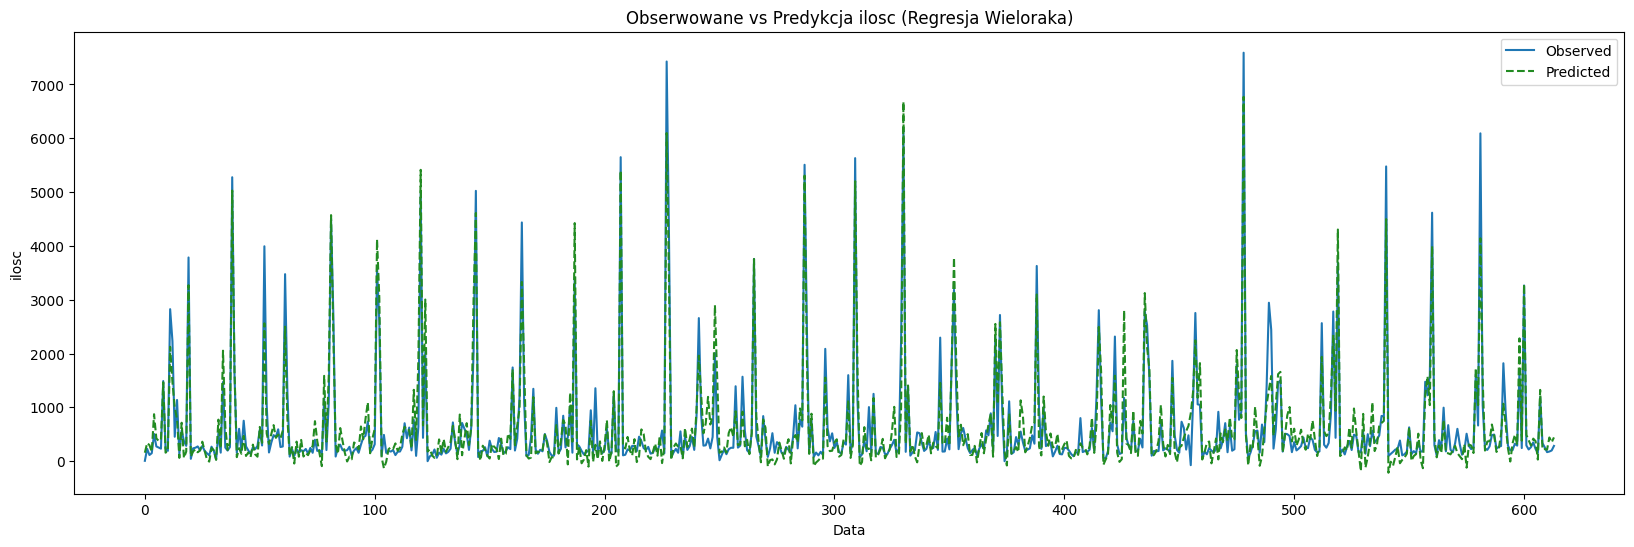

In [9]:
# Definicja zmiennych niezależnych i zależnych
X = data[[ 'articles', 'customers']]
y = data['ilosc']

# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X)

# Dopasowanie modelu regresji wielorakiej
model_multi = sm.OLS(y, X).fit()

# Podsumowanie modelu
summary_multi = model_multi.summary()
print(summary_multi)

# Predykcje
data['predicted'] = model_multi.predict(X)

# Wykres
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--', color = 'forestgreen')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     2652.
Date:                Tue, 25 Jun 2024   Prob (F-statistic):          6.51e-302
Time:                        07:33:20   Log-Likelihood:                -4429.4
No. Observations:                 614   AIC:                             8865.
Df Residuals:                     611   BIC:                             8878.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        197.1874     52.356      3.766      0.0

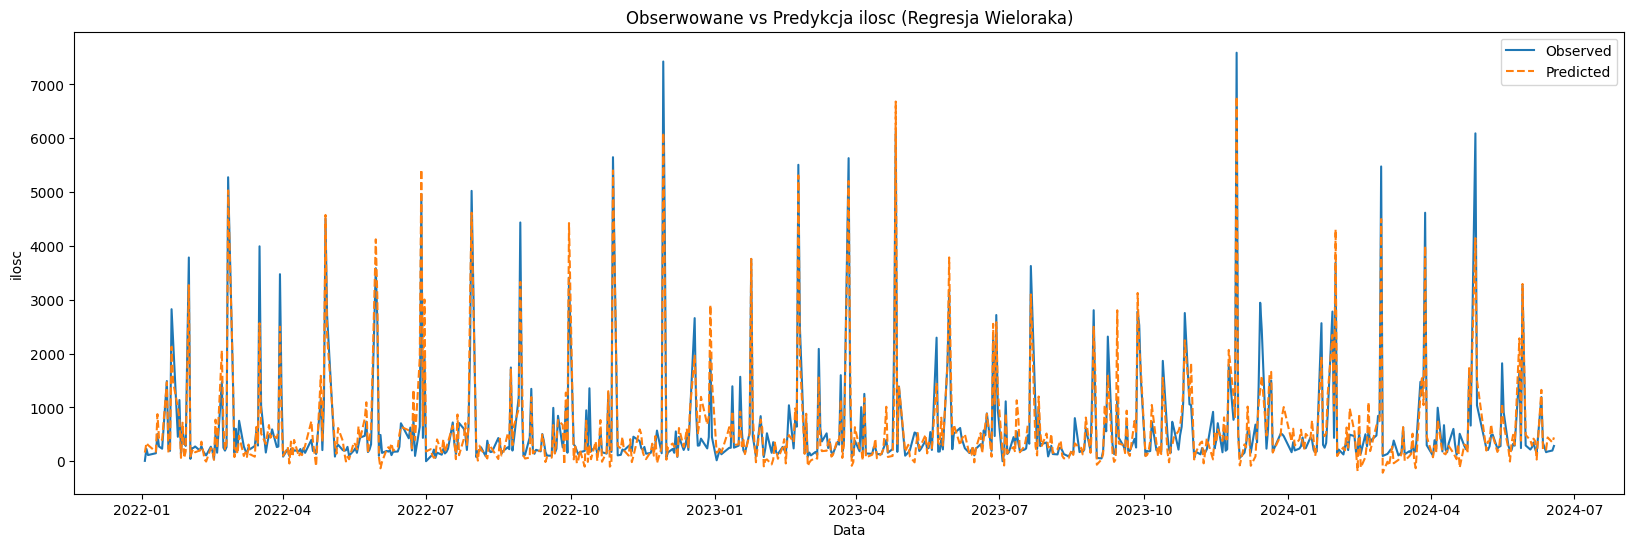

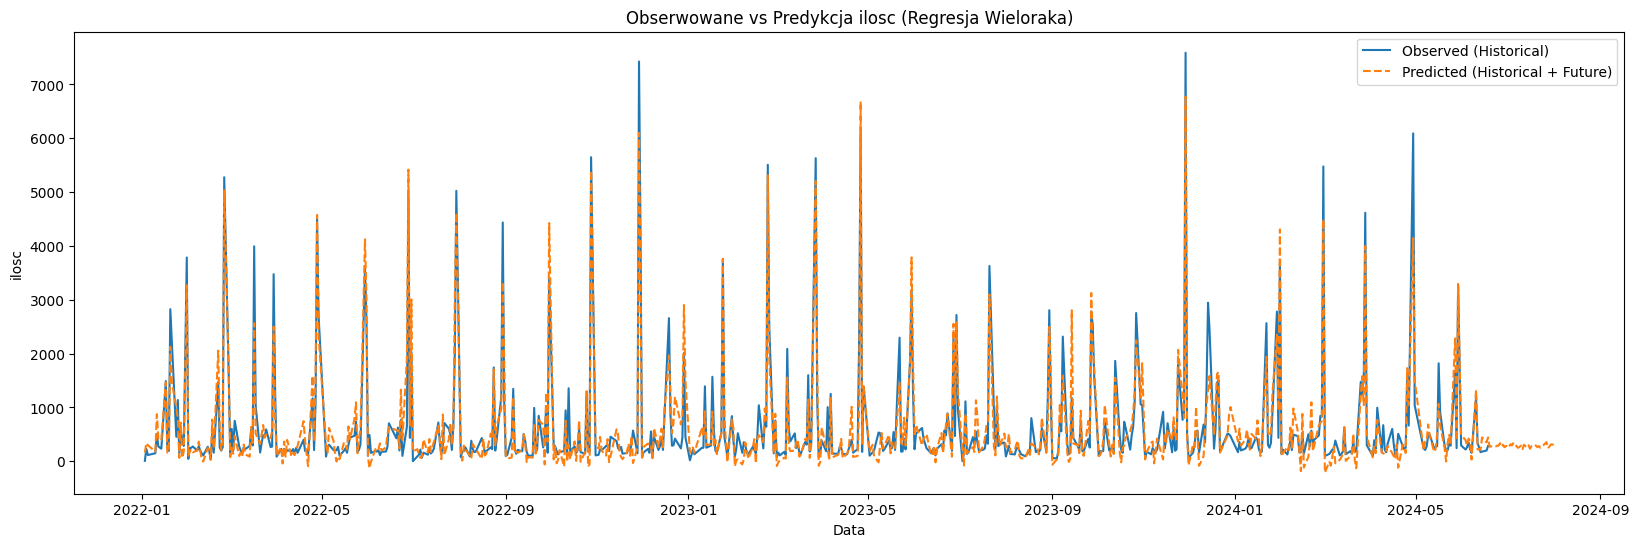

In [95]:

import matplotlib.pyplot as plt
# Wczytaj dane z pliku CSV
data = pd.read_csv('Prognoza_transformed.csv', sep=',' ,parse_dates=['date'])
# Assuming 'data' is already defined and contains the historical data

# Ensure 'DATA_W' is datetime and set as index if not already done
if not pd.api.types.is_datetime64_any_dtype(data['date']):
    data['date'] = pd.to_datetime(data['date'])

data.set_index('date', inplace=True)

# Definicja zmiennych niezależnych i zależnych
X = data[['articles', 'customers']]
y = data['ilosc']

# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X)

# Dopasowanie modelu regresji wielorakiej
model_multi = sm.OLS(y, X).fit()

# Podsumowanie modelu
summary_multi = model_multi.summary()
print(summary_multi)

# Predykcje na podstawie danych historycznych
data['predicted'] = model_multi.predict(X)

# Wykres danych historycznych i predykcji
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

# Prognozowanie na przyszłość (44 dni)

# Ensure the future data arrays are the same length
assert len(future_articles) == len(future_customers) == 44, "Future data arrays must be of length 44"

# Adding a constant (intercept) to future data
future_exogenous = np.column_stack([np.ones(future_articles.shape[0]), future_articles, future_customers])

# Predicting future values
future_predicted = model_multi.predict(future_exogenous)

# Create a dataframe for future dates
last_date = data.index[-1]  # Ensure the last date is a datetime object
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=44, freq='D')
future_df = pd.DataFrame({'articles': future_articles, 'customers': future_customers, 'predicted': future_predicted}, index=future_dates)

# Combine historical data with future predictions
combined_data = pd.concat([data[['ilosc', 'predicted']], future_df])

# Wykres danych historycznych i prognoz
plt.figure(figsize=(20, 6))
plt.plot(combined_data.index, combined_data['ilosc'], label='Observed (Historical)')
plt.plot(combined_data.index, combined_data['predicted'], label='Predicted (Historical + Future)', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     2652.
Date:                Tue, 25 Jun 2024   Prob (F-statistic):          6.51e-302
Time:                        08:11:03   Log-Likelihood:                -4429.4
No. Observations:                 614   AIC:                             8865.
Df Residuals:                     611   BIC:                             8878.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        197.1874     52.356      3.766      0.0

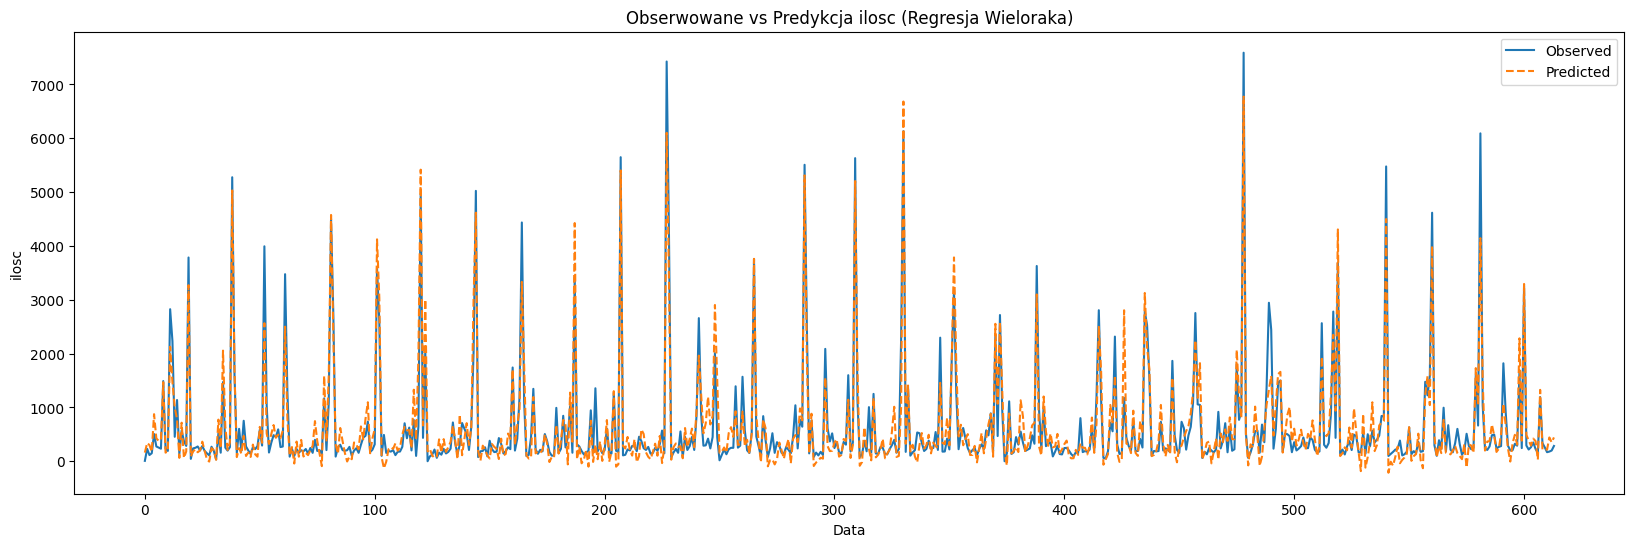

In [126]:
# Definicja zmiennych niezależnych i zależnych
X = data[['articles', 'customers']]
y = data['ilosc']

# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X)

# Dopasowanie modelu regresji wielorakiej
model_multi = sm.OLS(y, X).fit()

# Podsumowanie modelu
summary_multi = model_multi.summary()
print(summary_multi)

# Predykcje na podstawie danych historycznych
data['predicted'] = model_multi.predict(X)

# Wykres danych historycznych i predykcji
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     2652.
Date:                Tue, 25 Jun 2024   Prob (F-statistic):          6.51e-302
Time:                        08:10:02   Log-Likelihood:                -4429.4
No. Observations:                 614   AIC:                             8865.
Df Residuals:                     611   BIC:                             8878.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        197.1874     52.356      3.766      0.0

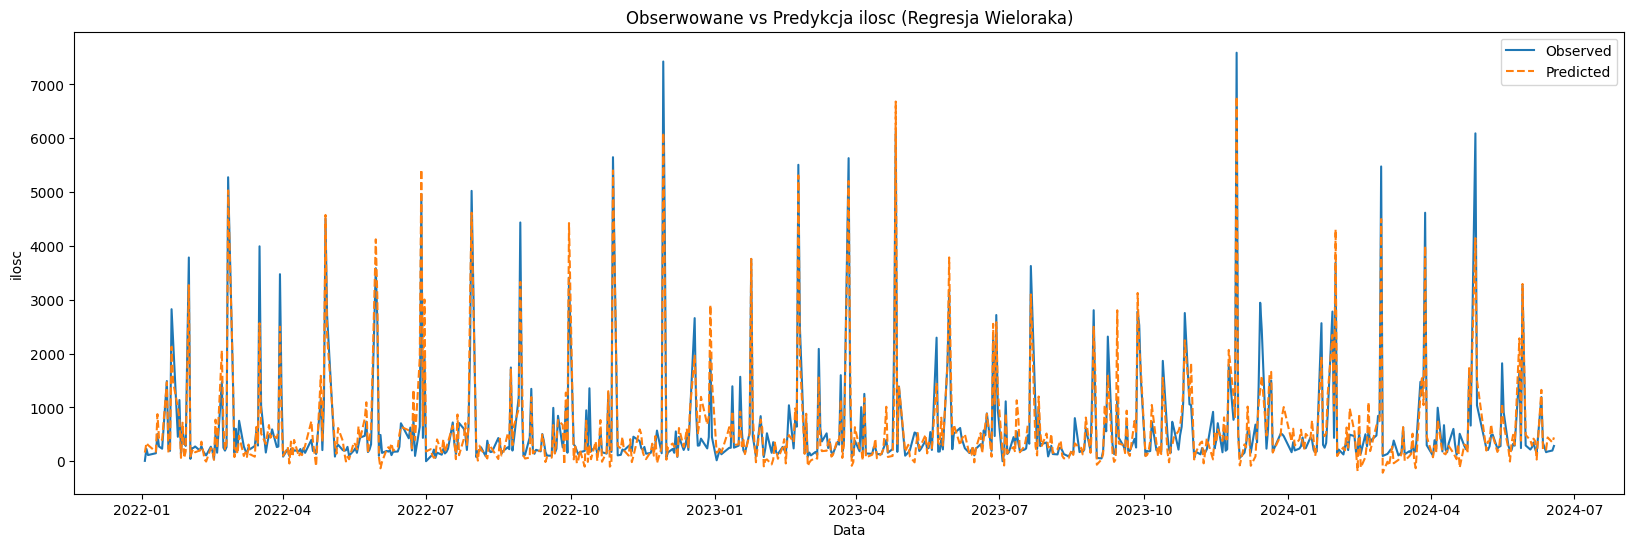

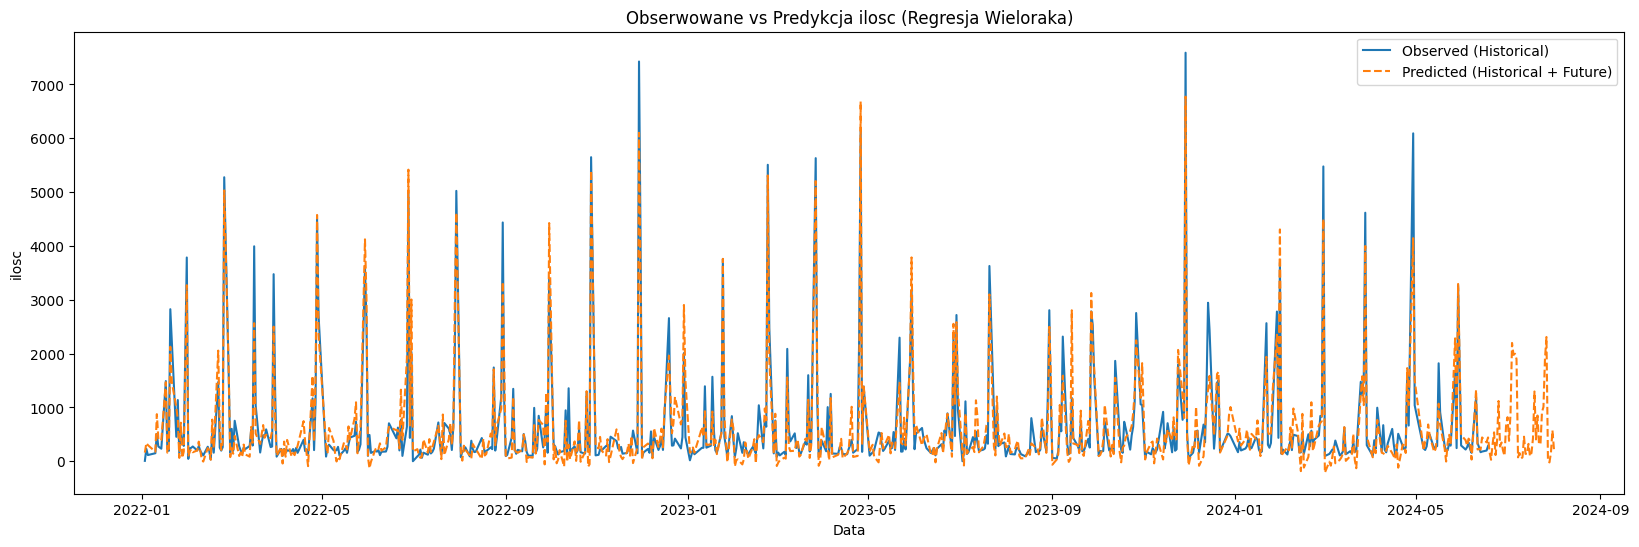

In [124]:
# Assuming data is already loaded into a DataFrame named 'data'

# Definicja zmiennych niezależnych i zależnych
X = data[['articles', 'customers']]
y = data['ilosc']

# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X)

# Dopasowanie modelu regresji wielorakiej
model_multi = sm.OLS(y, X).fit()

# Podsumowanie modelu
summary_multi = model_multi.summary()
print(summary_multi)

# Predykcje na podstawie danych historycznych
data['predicted'] = model_multi.predict(X)

# Wykres danych historycznych i predykcji
plt.figure(figsize=(20, 6))
plt.plot(data['date'], data['ilosc'], label='Observed')
plt.plot(data['date'], data['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

# Prognozowanie na przyszłość (44 dni)

# Ensure the future data arrays are the same length
assert len(future_articles) == len(future_customers) == 44, "Future data arrays must be of length 44"

# Adding a constant (intercept) to future data
future_exogenous = np.column_stack([np.ones(future_articles.shape[0]), future_articles, future_customers])

# Predicting future values
future_predicted = model_multi.predict(future_exogenous)

# Create a dataframe for future dates
last_date = pd.to_datetime(data['date'].max())  # Ensure the last date is a datetime object
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=44, freq='D')
future_df = pd.DataFrame({'articles': future_articles, 'customers': future_customers, 'predicted': future_predicted}, index=future_dates)

# Combine historical data with future predictions
combined_data = pd.concat([data[['date', 'ilosc', 'predicted']], future_df.reset_index().rename(columns={'index': 'date'})])

# Create the final dataframe with the required columns
final_df = pd.DataFrame({
    'date': combined_data['date'],
    'actual': combined_data['ilosc'].fillna(''),
    'predicted': combined_data['predicted'],
    'future_predicted': combined_data['predicted'].where(combined_data['date'] > last_date, '')
})

# Save the dataframe to a CSV file
final_df.to_csv('prediction_results_reg.csv', index=False)

# Wykres danych historycznych i prognoz
plt.figure(figsize=(20, 6))
plt.plot(combined_data['date'], combined_data['ilosc'], label='Observed (Historical)')
plt.plot(combined_data['date'], combined_data['predicted'], label='Predicted (Historical + Future)', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

# Obliczanie statystyk oceny modelu
mse = mean_squared_error(data['ilosc'], data['predicted'])
mae = mean_absolute_error(data['ilosc'], data['predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(data['ilosc'], data['predicted'])
aic = model_multi.aic
bic = model_multi.bic

# Przygotowanie danych do zapisu do Excela
evaluation_metrics = {
    'Metric': ['MSE', 'MAE', 'RMSE', 'R-squared', 'AIC', 'BIC'],
    'Value': [mse, mae, rmse, r2, aic, bic]
}

evaluation_df = pd.DataFrame(evaluation_metrics)
evaluation_df['Model'] = '1. Multiple Linear Regression'

# # Zapis do Excela
# with pd.ExcelWriter('model_evaluation_metrics.xlsx', mode='w', engine='openpyxl') as writer:
#     evaluation_df.to_excel(writer, sheet_name='Model 1', index=False)

# Display the final dataframe for confirmation
###import ace_tools as tools; tools.display_dataframe_to_user(name="Prediction Results", dataframe=final_df)


## XGBoost

MSE: 83640.29414769387
MAE: 172.15572721453415


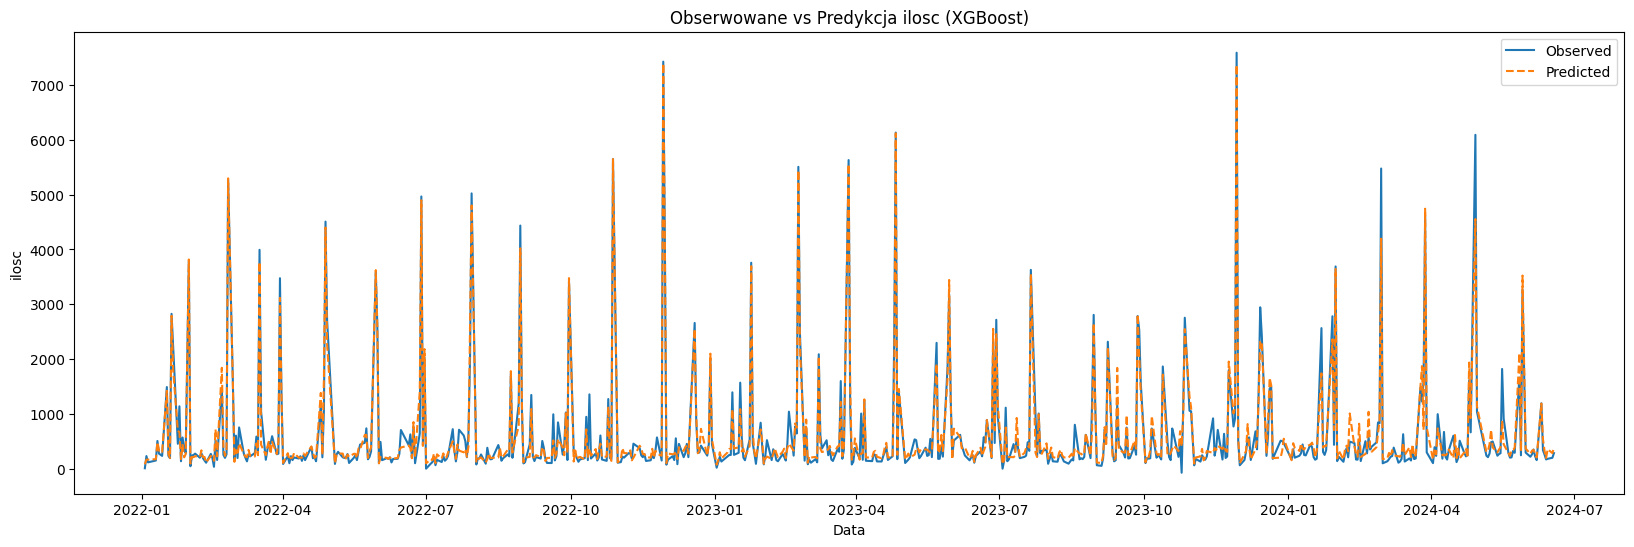

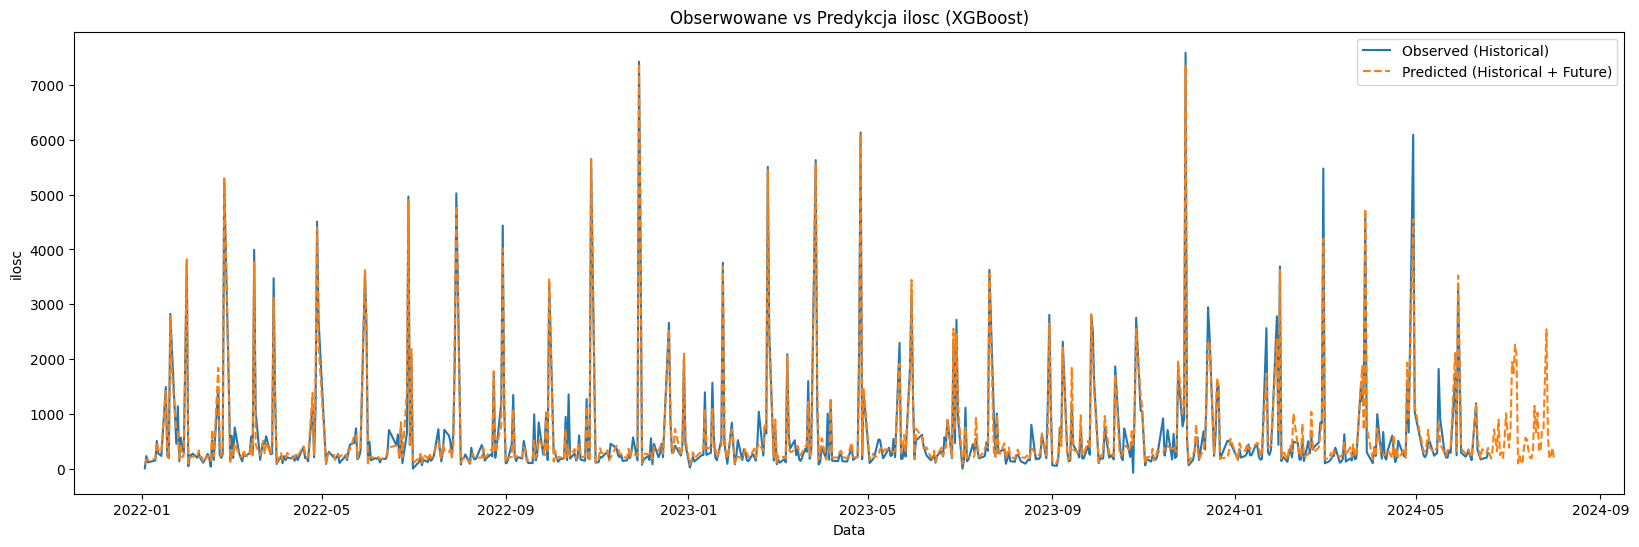

In [118]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Wczytaj dane z pliku CSV
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje
data = data.groupby(['DATA_W']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Utworzenie cech czasowych
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week
data['quarter'] = data['date'].dt.quarter

# Tworzenie cechy sinusoidalnej dla sezonowości miesięcznej
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Podział danych na cechy (X) i zmienną docelową (y)
X = data.drop(columns=['date', 'ilosc'])
y = data['ilosc']

# Podział danych na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Trenowanie modelu XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Prognozowanie na zestawie testowym
y_pred = model.predict(X_test)

# Obliczenie metryk na zestawie testowym
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# Ensure 'date' is datetime and set as index if not already done
data.set_index('date', inplace=True)

# Historical predictions using XGBoost
data['predicted'] = model.predict(X)

# Plotting historical data and predictions
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (XGBoost)')
plt.legend()
plt.show()

# Future prediction for 44 days
# Assuming future_forecast_articles and future_forecast_customers are provided
future_articles
future_customers

# Ensure the future data arrays are the same length
assert len(future_articles) == len(future_customers) == 44, "Future data arrays must be of length 44"

# Creating future DataFrame
last_date = data.index[-1]  # Ensure the last date is a datetime object
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=44, freq='D')

future_data = pd.DataFrame({
    'articles': future_articles,
    'customers': future_customers,
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'day_of_week': future_dates.dayofweek,
    'week_of_year': future_dates.isocalendar().week,
    'quarter': future_dates.quarter,
    'month_sin': np.sin(2 * np.pi * future_dates.month / 12),
    'month_cos': np.cos(2 * np.pi * future_dates.month / 12)
}, index=future_dates)

# Future prediction
future_predicted = model.predict(future_data)

# Combine historical data with future predictions
combined_data = pd.concat([data[['ilosc', 'predicted']], pd.DataFrame({'predicted': future_predicted}, index=future_dates)], axis=0)

# Create the final dataframe with the required columns
final_df = pd.DataFrame({
    'date': combined_data.index,
    'actual': combined_data['ilosc'].fillna(''),
    'predicted': combined_data['predicted'],
    'future_predicted': combined_data['predicted'].where(combined_data.index > last_date, '')
})

# Save the dataframe to a CSV file
final_df.to_csv('prediction_results_xgb.csv', index=False)

# Wykres danych historycznych i prognoz
plt.figure(figsize=(20, 6))
plt.plot(combined_data.index, combined_data['ilosc'], label='Observed (Historical)')
plt.plot(combined_data.index, combined_data['predicted'], label='Predicted (Historical + Future)', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (XGBoost)')
plt.legend()
plt.show()


MSE: 105253.20872867592
MAE: 187.15922464808025
RMSE: 324.4275092045616
R2: 0.8875244992353897


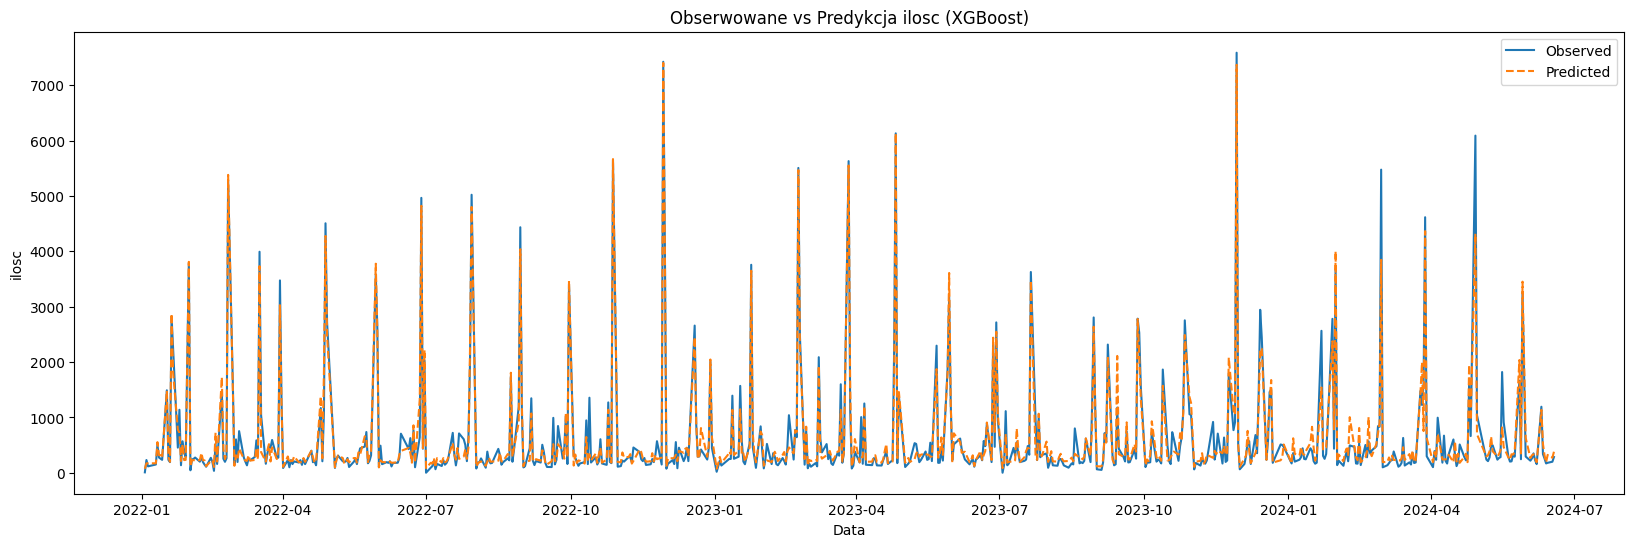

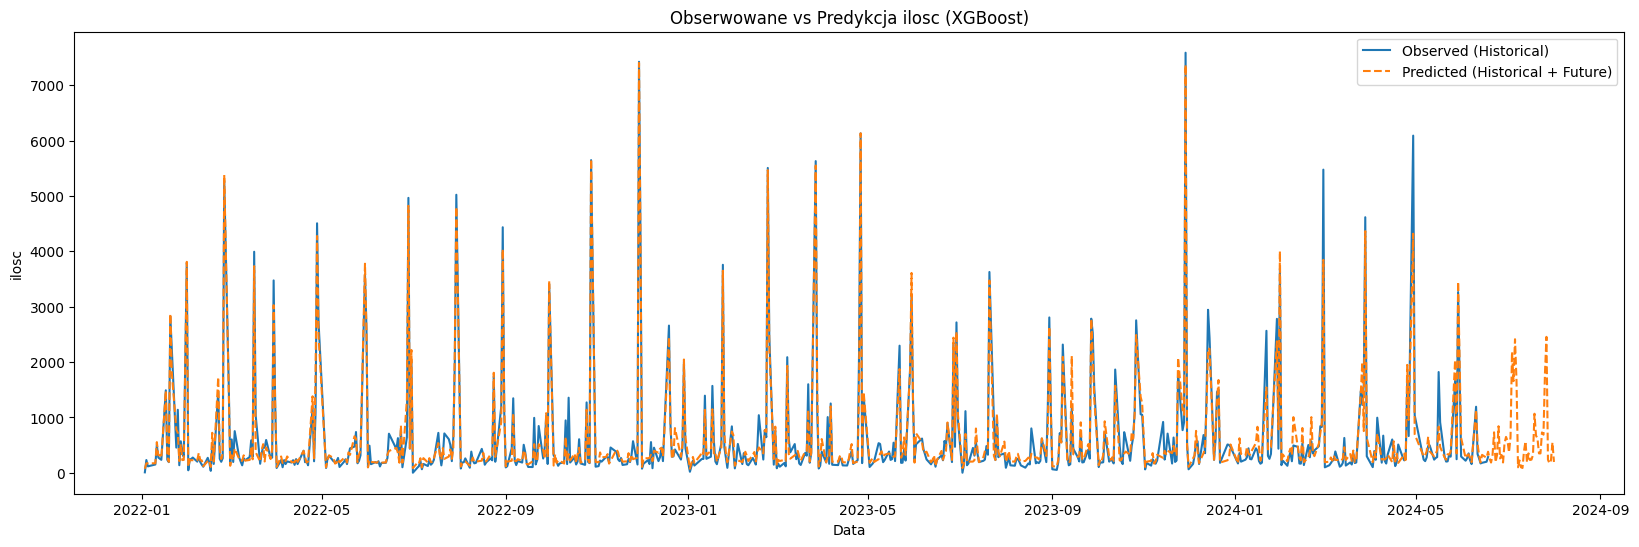

In [130]:

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


# Ensure 'date' is datetime and set as index if not already done
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Podział danych na cechy (X) i zmienną docelową (y)
selected_features = ['articles', 'customers', 'month', 'week_of_year', 'quarter', 
                     'is_last_days', 'is_first_days', 'is_saturday']

X = data[selected_features]
y = data['ilosc']

# Podział danych na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Trenowanie modelu XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Prognozowanie na zestawie testowym
y_pred = model.predict(X_test)

# Obliczenie metryk na zestawie testowym
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

# Historical predictions using XGBoost
data['predicted'] = model.predict(X)

# Plotting historical data and predictions
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (XGBoost)')
plt.legend()
plt.show()

# Future prediction for 44 days
# Assuming future_articles and future_customers are provided
# Ensure the future data arrays are the same length
assert len(future_articles) == len(future_customers) == 44, "Future data arrays must be of length 44"

# Creating future DataFrame
last_date = data.index[-1]  # Ensure the last date is a datetime object
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=44, freq='D')

future_data = pd.DataFrame({
    'articles': future_articles,
    'customers': future_customers,
    'month': future_dates.month,
    'week_of_year': future_dates.isocalendar().week,
    'quarter': future_dates.quarter,
    'is_last_days': future_dates.day.isin([28, 29, 30]).astype(int),
    'is_first_days': future_dates.day.isin([1, 2, 3, 4, 5]).astype(int),
    'is_saturday': (future_dates.dayofweek == 5).astype(int)
}, index=future_dates)

# Future prediction
future_predicted = model.predict(future_data)

# Combine historical data with future predictions
combined_data = pd.concat([data[['ilosc', 'predicted']], pd.DataFrame({'predicted': future_predicted}, index=future_dates)], axis=0)

# Create the final dataframe with the required columns
final_df = pd.DataFrame({
    'date': combined_data.index,
    'actual': combined_data['ilosc'].fillna(''),
    'predicted': combined_data['predicted'],
    'future_predicted': combined_data['predicted'].where(combined_data.index > last_date, '')
})

# Save the dataframe to a CSV file
final_df.to_csv('prediction_results_xgb.csv', index=False)

# Wykres danych historycznych i prognoz
plt.figure(figsize=(20, 6))
plt.plot(combined_data.index, combined_data['ilosc'], label='Observed (Historical)')
plt.plot(combined_data.index, combined_data['predicted'], label='Predicted (Historical + Future)', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (XGBoost)')
plt.legend()
plt.show()

# Przygotowanie danych do zapisu do Excela
evaluation_metrics = {
    'Metric': ['MSE', 'MAE', 'RMSE', 'R-squared'],
    'Value': [mse, mae, rmse, r2]
}

evaluation_df = pd.DataFrame(evaluation_metrics)
evaluation_df['Model'] = '2. XGBoost Regression'

# # Zapis do Excela
# with pd.ExcelWriter('model_evaluation_metrics.xlsx', mode='a', engine='openpyxl') as writer:
#     evaluation_df.to_excel(writer, sheet_name='Model 2', index=False)

# # Display the final dataframe for confirmation
# import ace_tools as tools; tools.display_dataframe_to_user(name="Prediction Results", dataframe=final_df)


## LSTM

### Przygotowanie danych

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])
# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Konwersja kolumny 'date' na format daty
data['date'] = pd.to_datetime(data['date'])
# Znalezienie articleid z największą liczbą dat
most_dates_articleid = data.groupby('articleid')['date'].nunique().idxmax()
print(f'Articleid z największą liczbą dat: {most_dates_articleid}')

# Filtrowanie danych dla wybranego articleid
article_data = data[data['articleid'] == most_dates_articleid]

# Grupowanie danych według daty, aby uzyskać dzienną sprzedaż
daily_sales = article_data.groupby('date').sum().reset_index()

# Wybranie tylko kolumny 'date' i 'ilosc'
daily_sales = daily_sales[['date', 'ilosc']]

# Ustawienie kolumny 'date' jako indeks
daily_sales.set_index('date', inplace=True)

# Upewnienie się, że dane są posortowane według daty
daily_sales.sort_index(inplace=True)

# Sprawdzenie liczby danych
print(daily_sales.head())
print(f'Liczba dni w danych: {len(daily_sales)}')



Articleid z największą liczbą dat: 20483
            ilosc
date             
2022-01-04  4.420
2022-01-05  1.547
2022-01-10  2.431
2022-01-11  6.851
2022-01-12  5.746
Liczba dni w danych: 607


In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])
# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Konwersja kolumny 'date' na format daty
data['date'] = pd.to_datetime(data['date'])

# Znalezienie articleid z największą liczbą dat
most_dates_articleid = data.groupby('articleid')['date'].nunique().idxmax()
print(f'Articleid z największą liczbą dat: {most_dates_articleid}')

# Filtrowanie danych dla wybranego articleid
article_data = data[data['articleid'] == most_dates_articleid]

# Grupowanie danych według daty, aby uzyskać dzienną sprzedaż
daily_sales = article_data.groupby('date').sum().reset_index()

# Wybranie tylko kolumny 'date' i 'ilosc'
daily_sales = daily_sales[['date', 'ilosc']]

# Zmiana granulacji na tygodniowe
weekly_sales = daily_sales.resample('W-Mon', on='date').sum().reset_index().sort_values(by='date')

# Ustawienie kolumny 'date' jako indeks
weekly_sales.set_index('date', inplace=True)

# Sprawdzenie liczby danych
print(weekly_sales.head())
print(f'Liczba tygodni w danych: {len(weekly_sales)}')

Articleid z największą liczbą dat: 20483
              ilosc
date               
2022-01-10    8.398
2022-01-17   40.664
2022-01-24  115.141
2022-01-31   91.936
2022-02-07   18.564
Liczba tygodni w danych: 129


### Lagi

X shape: (111, 10, 20)
y shape: (111,)
Epoch 1/50


c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0788 - val_loss: 0.0647
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0615 - val_loss: 0.0515
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0521 - val_loss: 0.0356
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0467 - val_loss: 0.0381
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0490 - val_loss: 0.0356
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0413 - val_loss: 0.0377
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0437 - val_loss: 0.0418
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0448 - val_loss: 0.0394
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0533 - val_loss: 0.0366
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0370 - val_loss: 0.0353
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0446 - val_loss: 0.0353
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0437 - val_loss: 0.0358
Epoch 13/50

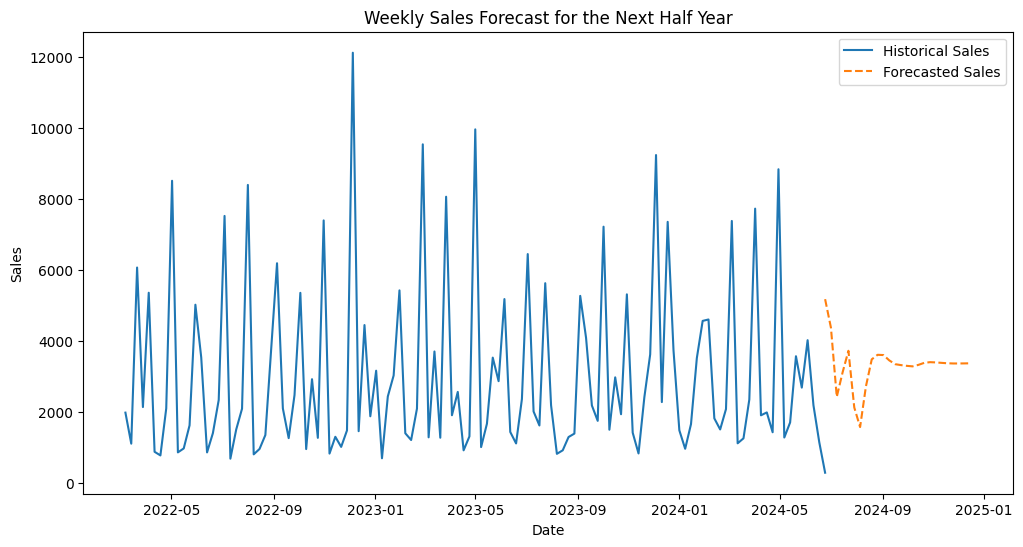

In [58]:
# Skalowanie danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weekly_sales)

# Tworzenie sekwencji dla modelu LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0])  # Zmienna docelowa to 'ilosc'
    return np.array(sequences), np.array(labels)

# Definicja długości sekwencji
seq_length = 10

# Sprawdzenie, czy mamy wystarczającą liczbę danych do tworzenia sekwencji
if len(scaled_data) > seq_length:
    # Przygotowanie sekwencji
    X, y = create_sequences(scaled_data, seq_length)

    # Sprawdzenie kształtu danych
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    # Przekształcenie X, aby miało wymiary (próbki, sekwencje, cechy)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    # Podział danych na zbiór treningowy i testowy
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Budowa modelu LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Trenowanie modelu
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Prognozowanie sprzedaży na najbliższe pół roku (26 tygodni)
    def predict_next_half_year(model, data, seq_length, steps=26):
        predictions = []
        current_sequence = data[-seq_length:]
        for _ in range(steps):
            current_sequence = current_sequence.reshape((1, seq_length, data.shape[1]))
            pred = model.predict(current_sequence)[0]
            predictions.append(pred)
            current_sequence = np.append(current_sequence[:, 1:, :], np.reshape(np.append(pred, current_sequence[0, -1, 1:]), (1, 1, data.shape[1])), axis=1)
        return np.array(predictions)

    # Prognozowanie na następne 26 tygodni
    predictions = predict_next_half_year(model, scaled_data, seq_length, steps=26)

    # Inwersja skalowania dla prognozowanych wartości
    predictions = scaler.inverse_transform(np.concatenate((predictions.reshape(-1, 1), np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Wyświetlenie prognozowanych wartości
    print(predictions)

    # Wizualizacja prognozowanych wartości
    dates = pd.date_range(start=weekly_sales.index[-1], periods=26, freq='W-Mon')
    forecast = pd.DataFrame(predictions, index=dates, columns=['Predicted Sales'])

    plt.figure(figsize=(12, 6))
    plt.plot(weekly_sales.index, weekly_sales['ilosc'], label='Historical Sales')
    plt.plot(forecast.index, forecast['Predicted Sales'], label='Forecasted Sales', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Weekly Sales Forecast for the Next Half Year')
    plt.legend()
    plt.show()

else:
    print("Niewystarczająca liczba danych do tworzenia sekwencji.")

X shape: (120, 10, 3)
y shape: (120,)
Epoch 1/400


c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 0.0840 - val_loss: 0.0597
Epoch 2/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0546 - val_loss: 0.0440
Epoch 3/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0595 - val_loss: 0.0332
Epoch 4/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0397 - val_loss: 0.0396
Epoch 5/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0514 - val_loss: 0.0329
Epoch 6/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0505 - val_loss: 0.0360
Epoch 7/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0486 - val_loss: 0.0329
Epoch 8/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0449 - val_loss: 0.0377
Epoch 9/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0422 - val_loss: 0.0341
Epoch 10/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0401 - val_loss: 0.0335
Epoch 11/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0480 - val_loss: 0.0328
Epoch 12/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0544 - val_loss: 0.0344


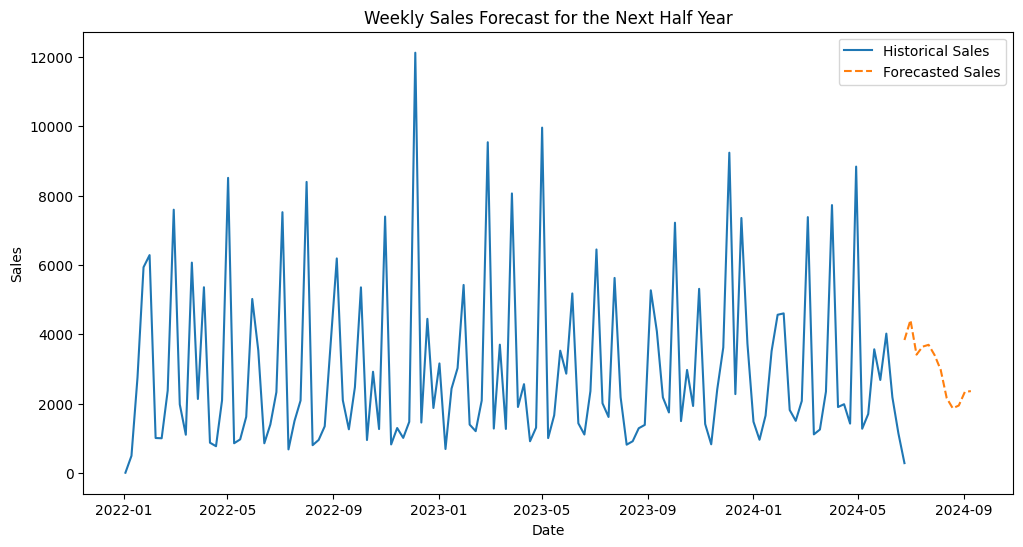

In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje tygodniowe 
data = data.groupby(['DATA_W']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Konwersja kolumny 'data_w' na format daty
data['data_w'] = pd.to_datetime(data['data_w'])

# Grupowanie danych według tygodnia, aby uzyskać tygodniową sprzedaż i liczbę klientów
weekly_sales = data.resample('W-Mon', on='data_w').sum().reset_index().sort_values(by='data_w')

# Usunięcie kolumny z datami przed skalowaniem
data_w_dates = weekly_sales['data_w']
weekly_sales_without_dates = weekly_sales.drop(columns=['data_w'])

# Skalowanie danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weekly_sales_without_dates)

# Tworzenie sekwencji dla modelu LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0])  # Zmienna docelowa to 'ilosc'
    return np.array(sequences), np.array(labels)

# Definicja długości sekwencji
seq_length = 10

# Sprawdzenie, czy mamy wystarczającą liczbę danych do tworzenia sekwencji
if len(scaled_data) > seq_length:
    # Przygotowanie sekwencji
    X, y = create_sequences(scaled_data, seq_length)

    # Sprawdzenie kształtu danych
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    # Przekształcenie X, aby miało wymiary (próbki, sekwencje, cechy)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    # Podział danych na zbiór treningowy i testowy
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Budowa modelu LSTM
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=(seq_length, X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Trenowanie modelu
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    history = model.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Prognozowanie sprzedaży na najbliższe pół roku (26 tygodni)
    def predict_next_half_year(model, data, seq_length, steps=26):
        predictions = []
        current_sequence = data[-seq_length:]
        for _ in range(steps):
            current_sequence = current_sequence.reshape((1, seq_length, data.shape[1]))
            pred = model.predict(current_sequence)[0]
            predictions.append(pred)
            current_sequence = np.append(current_sequence[:, 1:, :], np.reshape(np.append(pred, current_sequence[0, -1, 1:]), (1, 1, data.shape[1])), axis=1)
        return np.array(predictions)

    # Prognozowanie na następne 26 tygodni
    predictions = predict_next_half_year(model, scaled_data, seq_length, steps=12)

    # Inwersja skalowania dla prognozowanych wartości
    predictions = scaler.inverse_transform(np.concatenate((predictions.reshape(-1, 1), np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Wyświetlenie prognozowanych wartości
    print(predictions)

    # Wizualizacja prognozowanych wartości
    dates = pd.date_range(start=data_w_dates.iloc[-1], periods=12, freq='W-Mon')
    forecast = pd.DataFrame(predictions, index=dates, columns=['Predicted Sales'])

    plt.figure(figsize=(12, 6))
    plt.plot(data_w_dates, weekly_sales['ilosc'], label='Historical Sales')
    plt.plot(forecast.index, forecast['Predicted Sales'], label='Forecasted Sales', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Weekly Sales Forecast for the Next Half Year')
    plt.legend()
    plt.show()

else:
    print("Niewystarczająca liczba danych do tworzenia sekwencji.")
